In [2]:
pip install torch transformers spacy tensorflow matplotlib datasets sklearn

Looking in indexes: https://nexus.irn.intel.politie/repository/pypi-politie/simple
Note: you may need to restart the kernel to use updated packages.


In [936]:
import spacy
import torch
import random
import json
import re
import tensorflow as tf
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import datasets
from datasets import load_dataset, load_metric
import string
import torch.nn.functional as F
import sklearn
from sklearn.model_selection import train_test_split
import transformers
from transformers import (
    BertModel,
    BertTokenizer,
    BertForPreTraining,
    BertConfig,
    BertForMaskedLM,
    Trainer,
    TrainingArguments
)
from transformers.trainer_utils import get_last_checkpoint

In [8]:
#pip install 'en_core_web_lg.tar.gz'
nlp = spacy.load('en_core_web_lg-3.2.0/en_core_web_lg/en_core_web_lg-3.2.0')

In [794]:
#load in IMDB dataset
dataset_imdb = load_dataset('csv', data_files = "IMDB-review-sentiment.csv")
dataset_imdb.keys()
dataset_imdb = dataset_imdb.map(lambda x: {"len":len(x['review'])})
dataset_imdb = dataset_imdb.map(lambda x: {"next_sentence_label":0})
max(dataset_imdb['train']['len'])
dataset_imdb = dataset_imdb['train'].train_test_split(test_size=0.2)

Using custom data configuration default-0cd2026000bdb6b0
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-0cd2026000bdb6b0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)
100%|██████████| 1/1 [00:00<00:00, 239.21it/s]
Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-0cd2026000bdb6b0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-ac7e3b60ed8a41f4.arrow
Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-0cd2026000bdb6b0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-bb5c1fcb8dbfcd52.arrow


In [1020]:
#function for preprocessing the test dataset and splitting the dataset into chunks of 10000
#remove new line "<br />", remove '\\'
chunks =[]

def preproc(dataset):
    preproc_list =[]
    nobackslash_list=[]
    
    for sub in dataset_imdb['test']['review']: 
        preproc_list.append(sub.replace("<br />", " "))

    for ele in preproc_list:
        nobackslash_list = ele.strip('\\')
    
    concatenated_list = ' '.join(preproc_list)
    
    global chunks
    chunks = [concatenated_list[x:x+10000] for x in range(0, len(concatenated_list), 10000)]
    

In [756]:
preproc(dataset_imdb)

In [747]:
docs = list(nlp.pipe(chunks))

In [931]:
#create test dataset by masking every seventh occurrence of the attribute (approximately 14,3%)
#We pick the 5 most common entities: in this case this is PERSON, ORG, CARDINAL, GPE and DATE. 

gpe = 'GPE'
cardinal = 'CARDINAL'
date = 'DATE'
org = 'ORG'
person = 'PERSON'
rand = 'RANDOM'

def createDataset(attribute):
    count = 0
    result = []

    for doc in docs: 
        for token in doc:
            if token.ent_type_ == attribute: 
                count+=1
            if token.ent_type_ == attribute and count % 7 == 0:
                result.append("[MASK]")
            else:
                result.append(token.text)
            result.append(token.whitespace_)
            
    global test_dataset
    test_dataset = ''.join(result)
    
    with open(attribute+'_test_dataset', 'w') as f:
        f.write(test_dataset)
    
    #return test_dataset
    #return count



In [971]:
createDataset(time)

In [819]:
#create random baseline dataset
#every seventh occurrence of the 5 most common attributes is masked
res = []
count=0

for doc in docs:
    for token in doc: 
        if token.ent_type_ =="PERSON":
            count +=1
        if token.ent_type_ == "PERSON" and (count % 7 == 0):
            res.append('[MASK]')
            
        if token.ent_type_ == "ORG":
            count+=1
        if token.ent_type_ == "ORG" and (count % 7 ==0):
            res.append('[MASK]')
            
        if token.ent_type_ == "CARDINAL":
            count+=1
        if token.ent_type_ == "CARDINAL" and (count % 7 ==0):
            res.append('[MASK]')
        
        if token.ent_type_ == "GPE":
            count+=1
        if token.ent_type_ == "GPE" and (count % 7 ==0):
            res.append('[MASK]')
            
        if token.ent_type_ == "DATE":
            count+=1
        if token.ent_type_ == "DATE" and (count % 7 ==0):
            res.append('[MASK]')
        
        else:
            res.append(token.text)
        res.append(token.whitespace_)

test_random = ''.join(res)

In [1022]:
#generate a word for the [MASK] tokens in the test dataset
def generate_sent(sentence):
    input = tokenizer.encode_plus(
        sentence, return_tensors="pt", truncation=True, max_length=512
    )
    tokens = input["input_ids"][0]
    mask_index = torch.where(
        (tokens == tokenizer.mask_token_id)
        & (  # pick masked
            (
                (torch.roll(tokens, 1) != tokenizer.mask_token_id)
                & (torch.roll(tokens, 1) != tokenizer.cls_token)
            )  
            | (
                (torch.roll(tokens, -1) != tokenizer.mask_token_id)
                & (torch.roll(tokens, -1) != tokenizer.sep_token_id)
            ) 
        )
    )[0]

    if len(mask_index) == 0:
        return sentence, []
    else:
        mask_index = mask_index[0]
    output = model(**input)
    logits = output.logits
    softmax = F.softmax(logits, dim=-1)
    mask_word = softmax[0, mask_index, :]
    #randomly pick a word from the top 10 choices
    top = torch.topk(mask_word, 10, dim=-1)[1]
    token = random.choice(top)
    tokens[mask_index] = token
    return tokenizer.decode(tokens[1:-1]), tokenizer.decode([token])

#returns a tuple containing the generated text and a list containing all masks
def generate(start):
    tokens = []
    while tokenizer.mask_token in start:
        start, tok = generate_sent(start)
        tokens.append(tok)
    return start, tokens
    
    
#split the sentences at interpunction, if the sentence contains a [MASK], generate a word
def fill_masks_chunks(text):
    sents = re.split("[,.?!]", text)
    generated_sents = [generate(sent) for sent in sents]
    tup = tuple(zip(*generated_sents))
    new_text = " ".join(tup[0])
    new_masks = [y for x in tup[1] for y in x]
    return new_text, new_masks

In [972]:
model_name = "/home/jovyan/model/output_final/bert1/"
tokenizer = BertTokenizer.from_pretrained('/home/jovyan/model/output_final/bert1/vocab.txt')
model = BertForMaskedLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))
model.eval()

#change to either test_dataset or test_random
new_data = fill_masks_chunks(test_dataset)

Some weights of the model checkpoint at /home/jovyan/model/output_final/bert1/ were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [976]:
#get the list of predicted tokens and calculate the probability of correctly predicted masks
acc=0

def accuracy(attribute):
    only_predicted_tokens = new_data[1]
    newdata= ' '.join(only_predicted_tokens)
    
    with open(attribute+'_allmasks_predicted', 'w') as f:
        f.write((str(new_data[1])))
    
    doc1 = nlp(newdata)
    
    count_success = 0
    count_all = 0

    for ents in doc1:
        if ents.ent_type_ == attribute:
            count_success+=1
            count_all+=1
        else:
            count_all+=1

    print(count_all)
    print(count_success)
    
    global acc
    acc = ((count_success/count_all)*100)
    return (acc)

In [975]:
accuracy(time)

1181
219


18.543607112616428

In [ ]:
#---------------------------------------------------

In [983]:
#count 10 most frequent occurrences in the PREDICTED MASKS & plot them.

def DrawPredicted(attribute):
    
    predicted_masks = open(attribute+'_allmasks_predicted', 'r').read()
    
    freq_count_predicted = Counter(predicted_masks.split()).most_common(10)

    nbars = len(freq_count_predicted)
    number = [item[1] for item in freq_count_predicted]
    labels = [item[0] for item in freq_count_predicted]
    width = [0.5]
    plt.bar(np.arange(nbars), number, tick_label = labels, width = width)
    plt.xticks(rotation=45)

    plt.xlabel('Predicted ' + attribute + ' Entities')
    plt.ylabel('Number of Occurrences')
    plt.suptitle('The 10 Most Common Predicted '+  attribute + ' Entities.')

    fig1 = plt.gcf()
    fig1.show()
    fig1.tight_layout()
    fig1.savefig(attribute +'_predicted.jpg', dpi=99)

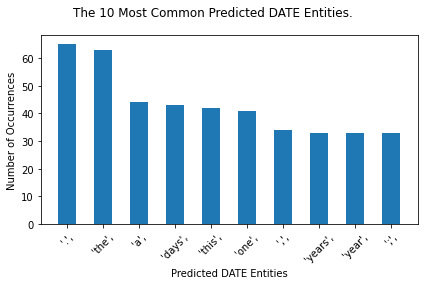

In [1014]:
DrawPredicted(date)

In [1001]:
#count 10 most frequent occurrences in the TESTDATASET & plot them.
def drawMostCommonTest(attribute):
    freq_dataset = []
    most_10freq =[]

    for doc in docs: 
        freq_dataset.append([ent.text for ent in doc.ents if ent.label_ == attribute])
        
    freq_count = Counter(x for xs in freq_dataset for x in set(xs))
    most_10freq = freq_count.most_common(10)  
    
    nbars = len(most_10freq)
    number = [item[1] for item in most_10freq]
    labels = [item[0] for item in most_10freq]
    width = [0.5]
    plt.bar(np.arange(nbars), number, tick_label = labels, width = width)
    plt.xticks(rotation=45)

    plt.xlabel(attribute + ' Entities in the Test Dataset.')
    plt.ylabel('Number of Occurrences')
    plt.suptitle('10 Most Common ' +attribute + ' Entities in the Test Dataset.')

    fig1 = plt.gcf()
    fig1.show()
    fig1.tight_layout()
    fig1.savefig(attribute +'_test.jpg', dpi=99)
    
    #uncomment for a list of the 10 most common entities.
    #return most_10freq



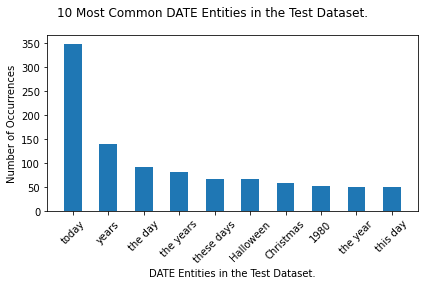

In [1013]:
drawMostCommonTest(date)